In [1]:
# !pip install imageio
# !pip install keras
%matplotlib inline

In [2]:
import numpy as np
import imageio
import tensorflow as tf
import matplotlib.pyplot as plt

import keras

Using TensorFlow backend.


# Global Constants

In [3]:
### DEFINE CONSTANTS

# Connect all components for end-to-end training
END_TO_END = False

# Prioritization of gradient support vs fidelity of critic applicator
FIDELITY = 0.1

# Size of plausible input size
N = 256 # (Pad images to this size with WHITE.)

# Color MSE tolerance
MSE_TOL = 3.0 / 256.0

CONST_k = 16.0
CONST_p = 1.0012131648204332 # Obtained from a rather exhaustive optimization

# MIGHT WANT TO INCREASE DURING TRAINING
SMC = -2.0
SML = -2.0

In [4]:
# Some functions
class PushPlus(keras.engine.topology.Layer):
    
    def __init__(self, **kwargs):
        super(PushPlus, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.var = self.add_weight(name='var',
                                   shape=(1, input_shape[1]),
                                   initializer='zeros',
                                   trainable=True)
        super(PushPlus, self).build(input_shape)
        
    def call(self, x, activation=None):
        ret = keras.layers.Add()([x, self.var])
        if activation is not None:
            if isinstance(activation, str):
                ret = keras.layers.Activation(activation)(ret)
            else:
                ret = activation(ret)
        return ret
    
    def compute_output_shape(self, input_shape):
        return (1, input_shape[1])
    
class VarLike(keras.engine.topology.Layer):
    
    def __init__(self, **kwargs):
        super(VarLike, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.var = self.add_weight(name='var',
                                   shape=(1, input_shape[1]),
                                   initializer='zeros',
                                   trainable=True)
        super(VarLike, self).build(input_shape)
        
    def call(self, x, activation=None):
        ret = self.var
        if activation is not None:
            if isinstance(activation, str):
                ret = keras.layers.Activation(activation)(ret)
            else:
                ret = activation(ret)
        return ret
    
    def compute_output_shape(self, input_shape):
        return (1, input_shape[1])
    
#     return tf.Variable(np.zeros([1] + x.shape.as_list()[1:]),
#                        name=x.name[:-2] + '_var',
#                        dtype=x.dtype,
#                        trainable=True)

## Global Inputs

In [5]:
# Inter-subnetwork variables
inputs = {}
inputs['state']    = keras.layers.Input(shape=(N, N, 3), name='state')
inputs['position'] = keras.layers.Input(shape=(2,), name='position')
inputs['width']    = keras.layers.Input(shape=(1,), name='width')
inputs['color']    = keras.layers.Input(shape=(3,), name='color')

# inputs['goal']     = keras.layers.Input(shape=(N, N, 3), 'goal')

exposed = {}
exposed['new_state'] = None

critic_input = {}

# Candidate Selection Network (Actor)

# Action Evaluation Network (Policy Actor)

In [7]:
jam_in = {}
if not END_TO_END:
    jam_in['start'] = keras.layers.Input(shape=(2,), name='p_start')
    jam_in['end']   = keras.layers.Input(shape=(2,), name='p_end')
    jam_in['width'] = keras.layers.Input(shape=(1,), name='p_width')
    jam_in['color'] = keras.layers.Input(shape=(3,), name='p_color')
    
    for k, x in jam_in.items():
        act = keras.backend.relu if k == 'width' else None
#         critic_input[k] = PushPlus()(x, activation=act)
        critic_input[k] = VarLike()(x, activation=act)
else:
    # Do end-to-end passing in of vals from Candidate Selector
    pass
    # TODO

# Dummy model (learn offset) to make sure that gradients are going back
# variables = {x: make_var_for(x) for x in [i_start, i_end, i_width]}

# width = i_width + N * tf.sigmoid(variables[i_width])
# start = N * tf.sigmoid(i_start + variables[i_start])
# end = N * tf.sigmoid(i_end + variables[i_end])

# Define Methods
# Input-invariant Tensors

class DrawLineLayer(keras.engine.topology.Layer):
    
    def __init__(self, start, end, width, color, method, **kwargs):
        anti_vec = [[-1.0, 1.0]]
        st_idx = np.stack(np.meshgrid(np.r_[:N], np.r_[:N]), axis=2).astype('float32')
        
        line = end - start
        orth_bc = tf.nn.l2_normalize(tf.reverse(line, axis=[1]) * anti_vec, dim=1)
        orth_bc = tf.reshape(orth_bc, [-1, 1, 1, 2])
        
        mid_bc = tf.reshape((start + end) / 2.0, [-1, 1, 1, 2])
        recentered = st_idx - mid_bc
        reoriented = recentered * orth_bc
        dotp = tf.square(tf.reduce_sum(reoriented, axis=3, keep_dims=True))
        trough = np.square(width / 2.0) - dotp

        length = (tf.norm(line, ord='euclidean') + width) / 2.0
        sphere = tf.square(length) - tf.square(tf.reduce_sum(recentered, axis=3, keep_dims=True))
        self.mask = tf.sigmoid(tf.exp(SML) * trough) * tf.sigmoid(tf.exp(SMC) * sphere)
        
        color_bc = tf.reshape(color, [-1, 1, 1, 3])
        self.plus = self.mask * color_bc
        super(DrawLineLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(DrawLineLayer, self).build(input_shape)
        
    def call(self, x):
        mask_minus = x * (1 - self.mask)
        return mask_minus + self.plus
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
def slope_sphere(start, end, width, line, orth_bc):
    """
    Get state mask by multiplying line by slope and circle by size
    """
    # Magic sharpening constant to reduce MAX anomaly
    
    
    return result


In [8]:
print(inputs['state'])

new_state = DrawLineLayer(critic_input['start'],
                          critic_input['end'],
                          critic_input['width'],
                          critic_input['color'],
                          slope_sphere)(inputs['state'])

print(new_state)

Tensor("state:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("draw_line_layer_1/add:0", shape=(?, 256, 256, 3), dtype=float32)


# Loss (Critic?)

In [9]:
def redraw_loss(goal, new_state):
    """Count only wrong pixel MSEs past a threshold. Batching done by keras."""
    mse = tf.reduce_sum(tf.square(goal - new_state), axis=3)
    counted_wrongs = tf.nn.relu(mse - MSE_TOL)
    goal_loss = keras.backend.sum(counted_wrongs, axis=(1, 2))
    return goal_loss

# exposed['wrongs'] = redraw_loss(inputs['goal'], new_state)

# MODEL  COMPILATION

In [16]:
MODEL_INPUTS = [inputs[k] for k in ['state']]
if not END_TO_END:
    MODEL_INPUTS += [jam_in[k] for k in ['start', 'end', 'width', 'color']]
else:
    # TODO
    pass

MODEL_OUTPUTS = [new_state]

model = keras.models.Model(inputs=MODEL_INPUTS, outputs=MODEL_OUTPUTS)
model.compile(optimizer='sgd', loss=[redraw_loss])

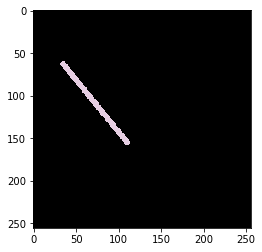

In [17]:
MOCK_GOAL = 1 - imageio.imread('./data/line_ex_1.png')[:,:,:3] / 255.0
plt.imshow(MOCK_GOAL)

In [18]:
INPUT_DICT = {
    'p_width': [5.0],
    'p_start': [50, 50],
    'p_end': [100.0,15.0],
    'p_color': [1.0,1.0,1.0],
    'state': np.zeros((N,N,3), dtype='float32')
}

# Pseudo-batching
for k, v in INPUT_DICT.items():
    INPUT_DICT[k] = np.array([v])
    
TARGET = np.array([MOCK_GOAL])
do_iter = 100
model.fit(epochs=do_iter, steps_per_epoch=1, x=INPUT_DICT, y=TARGET, verbose=2)


Epoch 1/100
 - 0s - loss: 1823.2852
Epoch 2/100
 - 0s - loss: 1823.2852
Epoch 3/100
 - 0s - loss: 1823.2852
Epoch 4/100
 - 0s - loss: 1823.2852
Epoch 5/100
 - 0s - loss: 1823.2852
Epoch 6/100
 - 0s - loss: 1823.2852
Epoch 7/100
 - 0s - loss: 1823.2852
Epoch 8/100
 - 0s - loss: 1823.2852
Epoch 9/100
 - 0s - loss: 1823.2852
Epoch 10/100
 - 0s - loss: 1823.2852
Epoch 11/100
 - 0s - loss: 1823.2852
Epoch 12/100
 - 0s - loss: 1823.2852
Epoch 13/100
 - 0s - loss: 1823.2852
Epoch 14/100
 - 0s - loss: 1823.2852
Epoch 15/100
 - 0s - loss: 1823.2852
Epoch 16/100
 - 0s - loss: 1823.2852
Epoch 17/100
 - 0s - loss: 1823.2852
Epoch 18/100
 - 0s - loss: 1823.2852
Epoch 19/100
 - 0s - loss: 1823.2852
Epoch 20/100
 - 0s - loss: 1823.2852
Epoch 21/100
 - 0s - loss: 1823.2852
Epoch 22/100
 - 0s - loss: 1823.2852
Epoch 23/100
 - 0s - loss: 1823.2852
Epoch 24/100
 - 0s - loss: 1823.2852
Epoch 25/100
 - 0s - loss: 1823.2852
Epoch 26/100
 - 0s - loss: 1823.2852
Epoch 27/100
 - 0s - loss: 1823.2852
Epoch 28/1

F:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


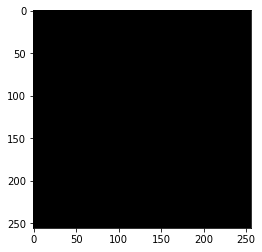

In [19]:
def show(im):
    toshow = 255.0 * (im - im.min()) / (im.max() - im.min())
    toshow = toshow.astype('uint8')
    plt.imshow(toshow)

out = model.predict(INPUT_DICT)[0]
show(out)


In [23]:
brush_params = [x for x in critic_input.values()]
param_model = keras.models.Model(inputs=MODEL_INPUTS,
                                 outputs=brush_params + [new_state])
intermediates = param_model.predict(INPUT_DICT)

[array([[ 0.,  0.]], dtype=float32),
 array([[ 0.,  0.]], dtype=float32),
 array([[ 0.]], dtype=float32),
 array([[ 0.,  0.,  0.]], dtype=float32)]

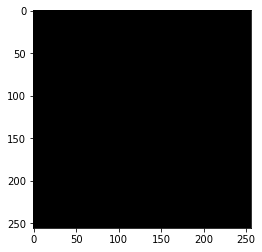

In [24]:
plt.imshow(intermediates[-1][0])
intermediates[:-1]

In [34]:
[INPUT_DICT[k] for k in ['p_start', 'p_end', 'p_width', 'p_color']]

[array([[50, 50]]),
 array([[ 100.,   15.]]),
 array([[ 5.]]),
 array([[ 1.,  1.,  1.]])]

In [35]:
# Gradients
theloss = redraw_loss(TARGET, new_state)
fn = keras.backend.function(brush_params, keras.backend.gradients(theloss, brush_params))
fn([INPUT_DICT[k] for k in ['p_start', 'p_end', 'p_width', 'p_color']])

InvalidArgumentError: Shape [-1,256,256,3] has negative dimensions
	 [[Node: state = Placeholder[dtype=DT_FLOAT, shape=[?,256,256,3], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'state', defined at:
  File "F:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "F:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "F:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "F:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "F:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "F:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "F:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "F:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "F:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "F:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "F:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "F:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "F:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "F:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "F:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "F:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "F:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "F:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "F:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "F:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-f6585724e720>", line 3, in <module>
    inputs['state']    = keras.layers.Input(shape=(N, N, 3), name='state')
  File "F:\ProgramData\Anaconda3\lib\site-packages\keras\engine\topology.py", line 1439, in Input
    input_tensor=tensor)
  File "F:\ProgramData\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "F:\ProgramData\Anaconda3\lib\site-packages\keras\engine\topology.py", line 1348, in __init__
    name=self.name)
  File "F:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 492, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,256,256,3] has negative dimensions
	 [[Node: state = Placeholder[dtype=DT_FLOAT, shape=[?,256,256,3], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


NameError: name 'do_iter' is not defined

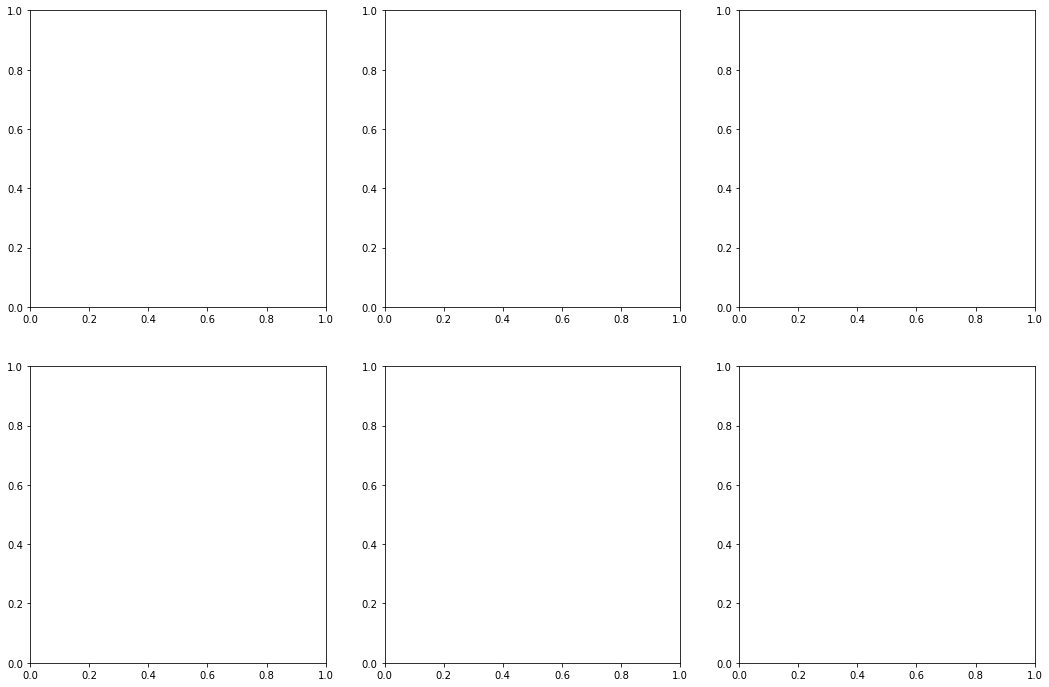

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

def st_at(idx):
    return results[idx]['new_state'][0]

def diff_at(idx):
    return normed_input - 1 + results[idx]['new_state'][0]

# Change
ax[0,0].imshow(st_at(do_iter - 1) - st_at(0))
# Init err
ax[0,1].imshow(diff_at(0))
# Init state
ax[0,2].imshow(st_at(0))
# Intermediate err
ax[1,0].imshow(diff_at((do_iter // 3) - 1))
# Last err
ax[1,1].imshow(diff_at(do_iter - 1))
# Last state
ax[1,2].imshow(st_at(do_iter - 1))
for a in ax.flat:
    a.set_axis_off()

In [15]:
def print_dict(d, pref=''):
    for k, i in d.items():
        print(pref, k, ':', i)

def inv_at_iter(i):
    print_dict(results[i])
    print('grads')
    print_dict(result_grads[i], '\t')
    # diff_at(do_iter - 1)
    
inv_at_iter(do_iter - 1)

NameError: name 'do_iter' is not defined

In [14]:
result_grads

NameError: name 'result_grads' is not defined